<a href="https://colab.research.google.com/github/MerkulovDaniil/mipt22/blob/main/notebooks/23_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание 2. 

The file should be sent in the `.pdf` format created via $\LaTeX$ or [typora](<https://typora.io/>) or printed from pdf with the colab\jupyter notebook. The only handwritten part, that could be included in the solution are the figures and illustrations.

**Deadline: 13.05.23 21:59:59**

# Conjugate gradients for non-quadratic functions

## Intro
The original CG algorithm is designed to minimize the quadratic function with SPD matrix:

$$
f(x) = \frac{1}{2} x^\top A x - b^\top x + c \to \min_{x \in \mathbb{R}^n}
$$

We start from some point $x_0 \in \mathbb{R}^n$ and initial direction $d_0 = r_0 = -\nabla f (x_0) = b - A x_0$. Then we form the whole procedure:

0. For $i = 0, 1, \ldots, n, \ldots$:

    1. $\alpha_i = \dfrac{r_i^\top r_i}{d_i^\top A d_i}$ - stepsize for the direction $d_i$ obtained from line search procedure.
    2. $x_{i+1} = x_i + \alpha_i d_i$ - step in the parameter space.
    3. $r_{i+1} = r_i - \alpha_i A d_i$ - residual at the new point. If it is already small enough, you can stop the algorithm there.
    4. $\beta_{i} = \dfrac{r_{i+1}^\top r_{i+1}}{r_{i}^\top r_{i}}$ - this multiplier will make $d_i$ and $d_{i+1}$ $A$- orthogonal to each other, i.e. $\langle d_{i+1}, A d_i \rangle = \langle d_{i+1}, d_i \rangle_A = 0$.
    5. $d_{i+1} = r_{i+1} + \beta_{i} d_i$ - new CG direction.

Note also, that typically, you precompute matvec $v_i = A d_i$ and use it where it is necessary, instead of computing it twice.

<font color="red"> ✅ TASK 1.1 </font>

Implement Conjugate Gradients method and run it on quadratic function.

In [183]:
import jax
from jax import numpy as jnp
from jax import random
from jax import grad
from matplotlib import pyplot as plt
RNG = random.PRNGKey(0)
n = 50
sigma = 0
A = random.normal(RNG, (n, n))
A = A.T@A

RNG, _ = random.split(RNG)
x_star = random.normal(RNG, (n,))

RNG, _ = random.split(RNG)
b = A @ x_star + sigma*random.normal(RNG, (n,))
A, b = jnp.array(A).astype(jnp.float32), jnp.array(b).astype(jnp.float32)
c = 0

x_0 = jnp.ones_like(x_star)

def f(x, A=A, b=b, c=c):
    return 1/2 * x.T @ A @ x - b.T @ x + c

def g(x, A=A, b=b, c=c):
    return A@x - b

def cg(x_0, A=A, b=b, f=f, g=g, n_iter=None):
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    d = -g(x_0)
    r = -g(x_0)
    f_star = f(x_star)

    trajectory = {}
    trajectory["xs"] = []
    trajectory["fs"] = []
    trajectory["f_gap"] = []
    trajectory["gs"] = []
    trajectory["x_gap"] = []
    trajectory["xs"].append(x)
    trajectory["fs"].append(f(x))
    trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
    trajectory["gs"].append(jnp.linalg.norm(g(x)))
    trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))

    for i in range(n_iter):
        ###
        # YOUR CODE HERE 
        ###
        
        trajectory["xs"].append(x)
        trajectory["fs"].append(f(x))
        trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
        trajectory["gs"].append(jnp.linalg.norm(g(x)))
        trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))
    return trajectory

In [184]:
metrics_cg = cg(x_0, n_iter=2*n)

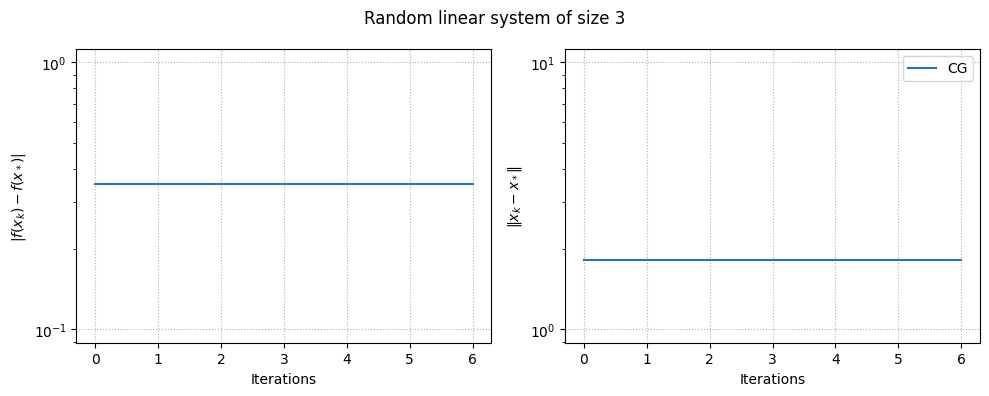

In [185]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Random linear system of size {n}")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_cg["f_gap"])
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_cg["x_gap"], label="CG")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

## From quadratic to general convex function

### Fletcher–Reeves method
We will replace step 1. with numerical line search (as soon as closed form solution for quadratic function is not valid anymore). All residuals will be replaced with antigradients.

We start from some point $x_0 \in \mathbb{R}^n$ and initial direction $d_0 = -g_0 = -\nabla f (x_0)$.

0. For $i = 0, 1, \ldots, n, \ldots$:

    1. $\alpha_i = \argmin\limits_{\alpha > 0}{f(x_i + \alpha d_i)}$ - stepsize for the direction $d_i$ obtained from line search procedure.
    2. $x_{i+1} = x_i + \alpha_i d_i$ - step in the parameter space.
    3. $g_{i+1} = \nabla f (x_{i+1})$ - gradient at the new point. If it is already small enough, you can stop the algorithm there.
    4. $\beta_{i} = \dfrac{g_{i+1}^\top g_{i+1}}{g_{i}^\top g_{i}}$.
    5. $d_{i+1} = -g_{i+1} + \beta_{i} d_i$ - new CG direction.

<font color="red"> ✅ TASK 1.2 </font>

Implement Fletcher–Reeves method and run it on Rosenbrock function.

In [60]:
from scipy.optimize import minimize_scalar

n = 2
x_0 = random.normal(RNG, (n,))
x_star = jnp.array([1.0, 1.0])

def f(x):
    return x[0]**4 - 2*x[0]**2*x[1] + x[0]**2 + x[1]**2 - 2*x[0] + 1

g = grad(f)

def cg_fr(x_0, f, g, n_iter=None):
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    d = -g(x_0)
    g_old = -g(x_0)
    f_star = f(x_star)

    trajectory = {}
    trajectory["xs"] = []
    trajectory["fs"] = []
    trajectory["f_gap"] = []
    trajectory["gs"] = []
    trajectory["x_gap"] = []
    trajectory["xs"].append(x)
    trajectory["fs"].append(f(x))
    trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
    trajectory["gs"].append(jnp.linalg.norm(g(x)))
    trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))

    for i in range(n_iter):
        ###
        # YOUR CODE HERE 
        ###
        
        trajectory["xs"].append(x)
        trajectory["fs"].append(f(x))
        trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
        trajectory["gs"].append(jnp.linalg.norm(g(x)))
        trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))
    return trajectory

In [61]:
metrics_fr = cg_fr(x_0, f, g, n_iter=60)

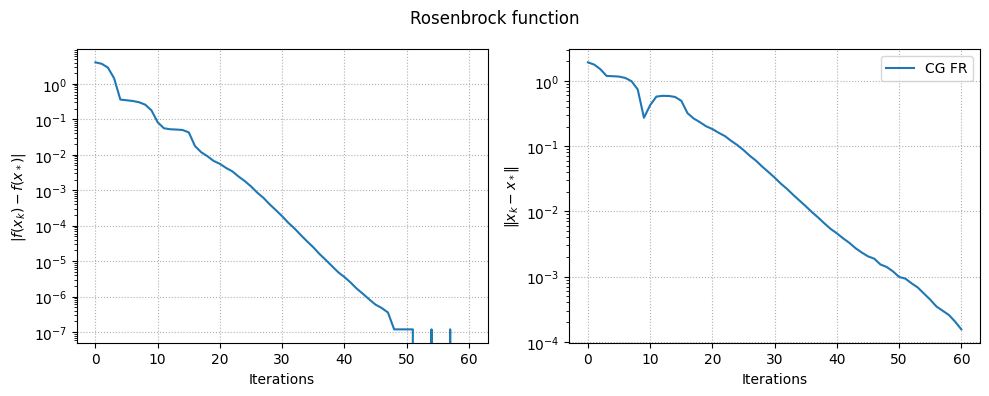

In [62]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Rosenbrock function")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_fr["f_gap"])
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_fr["x_gap"], label="CG FR")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

### Polak–Ribiere method
We will replace step 1. with numerical line search (as soon as closed form solution for quadratic function is not valid anymore). Here we want to replace the matvec from the original formula with the difference of the gradients:

$$
\nabla f(x_{i+1}) - \nabla f(x_i) = (A x_{i+1} - b) - (A x_i - b) = A(x_{i+1}-x_i) = \alpha_i A d_i
$$

$$
\alpha_i A d_i = \left( \nabla f(x_{i+1}) - \nabla f(x_i)\right) = g_{i+1} - g_i
$$

Also we reformulate the $\beta_i$ term from quadratic case

$$
\beta_{i} = \dfrac{r_{i+1}^\top r_{i+1}}{r_{i}^\top r_{i}} = \dfrac{(r_i - \alpha_i Ad_i)^\top r_{i+1}}{r_{i}^\top r_{i}} =  \dfrac{(g_{i+1} - g_i)^\top g_{i+1}}{g_{i}^\top g_{i}}
$$


We start from some point $x_0 \in \mathbb{R}^n$ and initial direction $d_0 = -g_0 = -\nabla f (x_0)$.

0. For $i = 0, 1, \ldots, n, \ldots$:

    1. $\alpha_i = \argmin\limits_{\alpha > 0}{f(x_i + \alpha d_i)}$ - stepsize for the direction $d_i$ obtained from line search procedure.
    2. $x_{i+1} = x_i + \alpha_i d_i$ - step in the parameter space.
    3. $g_{i+1} = \nabla f (x_{i+1})$ - gradient at the new point. If it is already small enough, you can stop the algorithm there.
    4. $\beta_{i} = \dfrac{(g_{i+1} - g_i)^\top g_{i+1}}{g_{i}^\top g_{i}}$.
    5. $d_{i+1} = -g_{i+1} + \beta_{i} d_i$ - new CG direction.

<font color="red"> ✅ TASK 1.3 </font>

Implement Polak–Ribiere method and run it on Rosenbrock function.

In [63]:
from scipy.optimize import minimize_scalar

n = 2
x_0 = random.normal(RNG, (n,))
x_star = jnp.array([1.0, 1.0])

def f(x):
    return x[0]**4 - 2*x[0]**2*x[1] + x[0]**2 + x[1]**2 - 2*x[0] + 1

g = grad(f)

def cg_pr(x_0, f, g, n_iter=None):
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    d = -g(x_0)
    g_old = -g(x_0)
    f_star = f(x_star)

    trajectory = {}
    trajectory["xs"] = []
    trajectory["fs"] = []
    trajectory["f_gap"] = []
    trajectory["gs"] = []
    trajectory["x_gap"] = []
    trajectory["xs"].append(x)
    trajectory["fs"].append(f(x))
    trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
    trajectory["gs"].append(jnp.linalg.norm(g(x)))
    trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))

    for i in range(n_iter):
        ###
        # YOUR CODE HERE 
        ###
        
        trajectory["xs"].append(x)
        trajectory["fs"].append(f(x))
        trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
        trajectory["gs"].append(jnp.linalg.norm(g(x)))
        trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))
    return trajectory

In [64]:
metrics_pr = cg_pr(x_0, f, g, n_iter=60)

<font color="red"> ✅ TASK 1.4 </font>

Plot results on the single figure for both Compare Fletcher–Reeves method and Polak–Ribiere method.

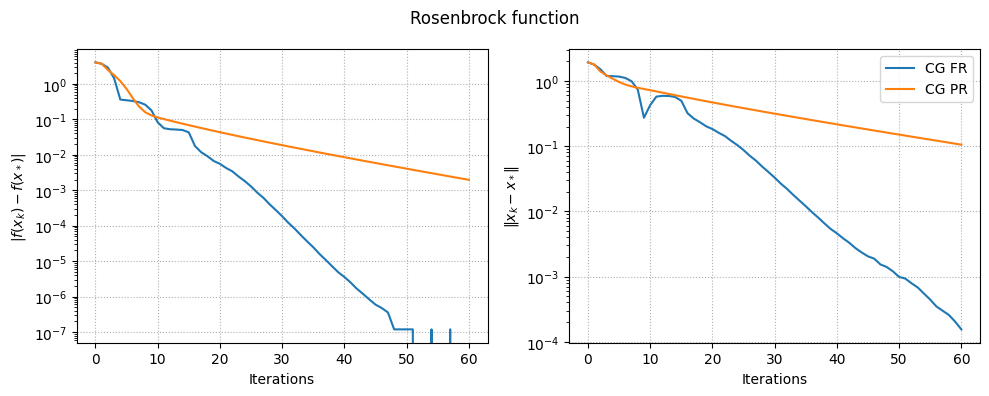

In [66]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Rosenbrock function")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$|f(x_k) - f(x_*)|$")
ax1.semilogy(metrics_fr["f_gap"], label="CG FR")
ax1.semilogy(metrics_pr["f_gap"], label="CG PR")
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|x_k - x_*\|$")
ax2.semilogy(metrics_fr["x_gap"], label="CG FR")
ax2.semilogy(metrics_pr["x_gap"], label="CG PR")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

<font color="red"> ✅ TASK 1.5 </font>

Prove analytically that all considered modifications of CG will work exactly the same as CG for the quadratic problem.
Support your proof with numerical comparison of CG, CG FR, CG PR methods for the quadratic problem of size $n = 100*M$, where $M$ is your birth month (For January $M = 1$, December $M = 12$).

In [ ]:
###
# YOUR CODE HERE 
###

<font color="red"> ✅ TASK 1.6 </font>

Consider the following convex non-quadratic problem, which arises in Machine Learning (indeed, this is loss function for the logistic regression problem with additional $l_2$ regularization):

$$
f(w) = \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) + \frac12 \|w\|_2^2  \to \min_w
$$

And compare the following algorithms:
* Fletcher–Reeves method
* Polak–Ribiere method
* Gradient Descent with constant learning rate $\alpha$
* Gradient Descent with line search

Use norm of the gradient as the stopping criterion. Fill the following table with the corresponding number of iterations:

| $\Vert\nabla f(x_k)\Vert \leq$ |  CG FR |  CG PR |  GD $\alpha = 10^{-3}$ |  GD $\alpha = 10^{-2}$ | GD $\alpha = 10^{-1}$  |  GD with Line Search |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| $10^{-3}$  |   |   |   |   |   |   |
| $10^{-4}$  |   |   |   |   |   |   |

In [77]:
import numpy as np
import sklearn.datasets as skldata
import jax
import jax.numpy as jnp

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, 
                                   n_informative=n//3, random_state=0)
X = jnp.array(X)
y = jnp.array(y)

@jax.jit
def f(w):
    return jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w))) + \
        jnp.linalg.norm(w)**2 / 2 

g = jax.jit(jax.grad(f))

RNG = random.PRNGKey(0)
# Don't forget, that you have to use the same initialization for each algorithm!
x0 = jax.random.normal(RNG, (n,))
print(f"🤖Initial function value = {f(x0)}")
print(f"🤖Initial gradient norm = {jnp.linalg.norm(g(x0))}")

🤖Initial function value = 171.20216369628906
🤖Initial gradient norm = 19.670339584350586


# Frank - Wolfe vs Projected subgradient descent

Consider the following simple quadratic optimization problem

$$
f(w) = \frac12 \langle Ax, x \rangle \to \min\limits_{x \in \mathbb{R}^n; \; 1^\top x = 1, \; x \succeq 0}
$$

<font color="red"> ✅ TASK 2.1 </font>
Solve this problem numerically with CVXPY and calculate optimal solution `x_star`

In [ ]:
from jax import random
from jax import grad

RNG = random.PRNGKey(0)
n = 100
A = random.normal(RNG, (n, n))
A = A.T@A

def f(x, A=A):
    return 1/2 * x.T @ A @ x 

g = grad(f)

def cvxpy_solution(A):
    ###
    # YOUR CODE HERE 
    ### x_star = jnp.array()
    return x_star

x_star = cvxpy_solution(A)

In this problem you will consider 3 algorithms for solving this problem
* Frank - Wolfe
* Projected Gradient Descent with stepsize $\alpha_k = \dfrac{2}{k+2}$
* Any algorithm of your choice

<font color="red"> ✅ TASK 2.2 </font>

Specify any stop criterion you like for the problem:

<font color="red"> ✅ TASK 2.3 </font>

Specify the third algorithm for the problem

<font color="red"> ✅ TASK 2.4 </font>

Fill the following table with the corresponding number of iterations, which is needed to reach the chosen stop criterion:

| Dimension of the problem  | Frank - Wolfe  | Projected Gradient Descent with $\alpha_k = \dfrac{2}{k+2}$  | MY ALGO  |
|:-:|:-:|:-:|:-:|
| $n=2$  |   |   |   |
| $n=10$  |   |   |   |
| $n=100$  |   |   |   |
| $n=1000$  |   |   |   |

In [285]:
import jax
from jax import numpy as jnp
from jax import random
from jax import grad
from matplotlib import pyplot as plt
RNG = random.PRNGKey(0)
n = 100
sigma = 0
A = random.normal(RNG, (n, n))
A = A.T@A

# Generate random vertex of a unit simples as an initial point
RNG, _ = random.split(RNG)
x_0 = jnp.zeros(n)
idx = random.randint(RNG, (1,), 0, n)
x_0 = x_0.at[idx].set(1.0)

def f(x, A=A):
    return 1/2 * x.T @ A @ x 

g = grad(f)

def FW(x_0, A=A, f=f, g=g, n_iter=None):
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    f_star = f(x_star)

    trajectory = {}
    trajectory["xs"] = []
    trajectory["fs"] = []
    trajectory["f_gap"] = []
    trajectory["gs"] = []
    trajectory["x_gap"] = []
    trajectory["xs"].append(x)
    trajectory["fs"].append(f(x))
    trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
    trajectory["gs"].append(jnp.linalg.norm(g(x)))
    trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))

    for i in range(n_iter):
        ###
        # YOUR CODE HERE 
        ###
        
        trajectory["xs"].append(x)
        trajectory["fs"].append(f(x))
        trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
        trajectory["gs"].append(jnp.linalg.norm(g(x)))
        trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))
    return trajectory

In [286]:
metrics_fw = FW(x_0, n_iter=300)

In [290]:
def PGD(x_0, A=A, f=f, g=g, n_iter=None):
    if n_iter is None:
        n_iter = len(x_0)
    x = x_0
    f_star = f(x_star)

    trajectory = {}
    trajectory["xs"] = []
    trajectory["fs"] = []
    trajectory["f_gap"] = []
    trajectory["gs"] = []
    trajectory["x_gap"] = []
    trajectory["xs"].append(x)
    trajectory["fs"].append(f(x))
    trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
    trajectory["gs"].append(jnp.linalg.norm(g(x)))
    trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))

    def Proj(v):
        """Compute the Euclidean projection of a vector `v` onto the unit simplex."""
        ###
        # YOUR CODE HERE 
        ###
        return
    
    for i in range(n_iter):
        alpha = 2/(i+2)
        ###
        # YOUR CODE HERE 
        ###
        
        trajectory["xs"].append(x)
        trajectory["fs"].append(f(x))
        trajectory["f_gap"].append(jnp.abs(f(x) - f_star))
        trajectory["gs"].append(jnp.linalg.norm(g(x)))
        trajectory["x_gap"].append(jnp.linalg.norm(x - x_star))
    return trajectory

In [291]:
metrics_pgd = PGD(x_0, n_iter=300)

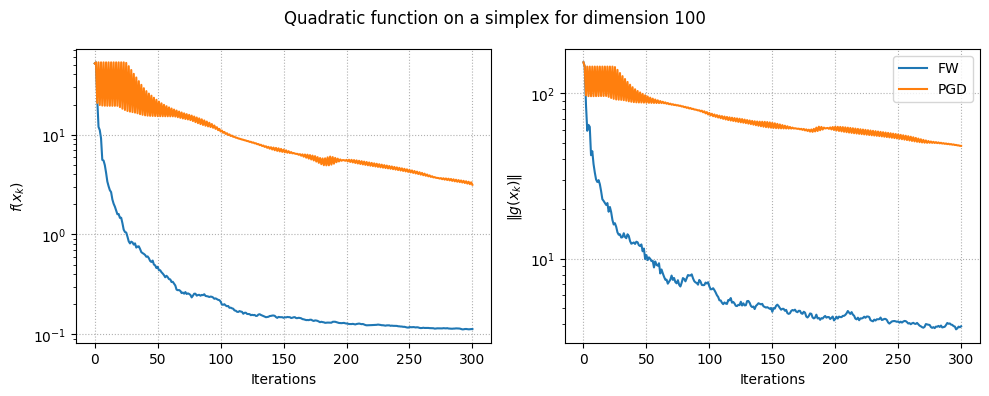

In [294]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Quadratic function on a simplex for dimension {n}")
ax1.set_xlabel("Iterations")
ax1.set_ylabel(f"$f(x_k) $")
ax1.semilogy(metrics_fw["fs"], label="FW")
ax1.semilogy(metrics_pgd["fs"], label="PGD")
ax1.grid(linestyle=":")

ax2.set_xlabel("Iterations")
ax2.set_ylabel(f"$\|g(x_k)\|$")
ax2.semilogy(metrics_fw["gs"], label="FW")
ax2.semilogy(metrics_pgd["gs"], label="PGD")
ax2.legend()
ax2.grid(linestyle=":")

plt.tight_layout()
plt.show()

# Stochastic gradient descent and applications